# Objetivos do caderno
- Selecionar 50% de homens e 50% de mulheres
- Salvar em uma lista o nome das pessoas selecionadas
- Extrair 10 extratos de áudio de cada

In [78]:
import pandas as pd
import numpy as np
import os
import sphfile as sph
import matplotlib.pyplot as plt
import librosa
import ipywidgets as widgets
import scipy.io.wavfile as wav
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sb

plt.style.use('ggplot')

import keras
import tensorflow as tf
from tensorflow.keras.layers import *

## Selecionar 50% homens e 50% mulheres

In [2]:
palestras=pd.read_excel("Registro_Palestrantes.xlsx",index_col=0)

In [3]:
palestras.Sexo.value_counts(normalize=True)

M    0.774366
F    0.225634
Name: Sexo, dtype: float64

In [4]:
palestras.Sexo.value_counts()

M    580
F    169
Name: Sexo, dtype: int64

In [5]:
samp_m=palestras[palestras.Sexo=='M'].sample(50)
samp_f=palestras[palestras.Sexo=='F'].sample(50)
samp=samp_m.append(samp_f)
samp=samp.sample(frac=1)

In [6]:
samp=samp.iloc[:,:5]

In [7]:
samp['Set2']=['Teste' if i>0.9 else 'Treino' for i in np.random.rand(samp.shape[0])]

In [8]:
samp['Set2'].value_counts()

Treino    89
Teste     11
Name: Set2, dtype: int64

In [9]:
samp.to_parquet('Palestrantes_Selecionados.parquet')

## Extrair 10 extratos de áudio de cada

In [10]:
try:
    samp==1
except:
    samp=pd.read_parquet('Palestrantes_Selecionados.parquet')

# #####
# Mudar o formato do dataframe
# #####

| Nome | Ano | Sexo | t_min | t_max 

In [11]:
samp=samp.reset_index(drop=True)

In [12]:
samp.Sexo=samp.Sexo.replace({'M':1,'F':0})

In [13]:
df=pd.DataFrame(columns=['Nome','Ano','Sexo','Set','t_min','t_max','AudioName'])

In [14]:
for indice in samp.index:
    try:
        nome=samp.loc[indice,'Nome'].replace(' ','')
        ano=str(samp.loc[indice,'Ano'])
        sexo=samp.loc[indice,'Sexo']
        set_=samp.loc[indice,'Set'].lower()
        audio_name=[x for x in os.listdir(f"TEDLIUM_release1/{set_}/sph/") if x.startswith(nome+'_'+ano)][0]
        audio=sph.SPHFile(f"TEDLIUM_release1/{set_}/sph/{audio_name}")
        texto=[x for x in os.listdir(f"TEDLIUM_release1/{set_}/stm/") if x.startswith(nome+'_'+ano)][0]
        tr=open((f"TEDLIUM_release1/{set_}/stm/{texto}"))
        texto=tr.readlines()
        tr.close()

        tempo=[tuple(tx.split(' ')[3:5]) for tx in texto]
        tempo=[(float(t[0]),float(t[1])) for t in tempo]
        duration=[float(t[1])-float(t[0]) for t in tempo]
        idx=np.where(pd.Series(duration)>2)[0]
        
        
        sr=audio.format['sample_rate']
        for t in range(len(idx)):
            init=np.round(tempo[idx[t]][0]+duration[idx[t]]*np.random.rand())
            end=init+2
            df=df.append(pd.DataFrame(dict(zip(df.columns,[nome,ano,sexo,set_,init,end,audio_name])),index=[0]),ignore_index=True)
        
        
#         corte=[(int(t[0]*sr),int(t[1]*sr)) for t in tempo]        
        
#         corte=[audio.content[c[0]:c[1]] for c in corte]
#         corte=[corte[i].astype(float) for i in idx]
        
    #    print(4)
#         for ct in corte:
#             along=0.95+0.1*np.random.rand()
#             intensidade=0.9+0.2*np.random.rand()
#             c_along=intensidade*librosa.effects.time_stretch(ct,along)
#     #        print(5)
#             for j in range(5):
#                 try:
#                     init=np.random.randint(c_along.shape[0]-32000)
#                     trilha=np.vstack([trilha,np.concatenate((c_along[init:init+32000],np.array([samp.loc[indice,'Sexo']])))])
#                 except:
#                     pass
    except:
        print(indice)

In [15]:
df['path']=df.Nome+'_'+df.Ano

In [16]:
df.to_csv('df_in.csv',index=False)

In [17]:
df.Nome.nunique()

96

In [18]:
df.head()

,Nome,Ano,Sexo,Set,t_min,t_max,AudioName,path
0,RichardBaraniuk,2006,1,train,1012.0,1014.0,RichardBaraniuk_2006.sph,RichardBaraniuk_2006
1,RichardBaraniuk,2006,1,train,1036.0,1038.0,RichardBaraniuk_2006.sph,RichardBaraniuk_2006
2,RichardBaraniuk,2006,1,train,111.0,113.0,RichardBaraniuk_2006.sph,RichardBaraniuk_2006
3,RichardBaraniuk,2006,1,train,1049.0,1051.0,RichardBaraniuk_2006.sph,RichardBaraniuk_2006
4,RichardBaraniuk,2006,1,train,1058.0,1060.0,RichardBaraniuk_2006.sph,RichardBaraniuk_2006


In [18]:
df.Sexo.value_counts(normalize=True)

1    0.504707
0    0.495293
Name: Sexo, dtype: float64

# -----------------
# MUDAR
# -----------------

In [2]:
try:
    type(df)==pd.DataFrame
except:
    df=pd.read_csv('./df_in.csv')

In [3]:
n_fft=512
hop_length=1024

In [4]:
def get_features(df_in):
    features=[] #list to save features
    labels=[] #list to save labels
    for index in range(0,len(df_in)):
        filename=f"TEDLIUM_release1/{df_in.loc[index,'Set']}/sph/{df_in.loc[index,'AudioName']}" #get the filename
        tstart = df_in.iloc[index]['t_min'] 
        tend = df_in.iloc[index]['t_max'] 
        species_id = df_in.iloc[index]['Sexo'] 
        #load the file
        sph_=sph.SPHFile(filename)
        y=np.array(sph_.time_range(df_in.loc[index,'t_min'],df_in.loc[index,'t_max']),dtype='float32')
        sr = sph_.format['sample_rate']
        data = np.array(librosa.feature.mfcc(y,n_fft=n_fft,hop_length=hop_length,n_mfcc=24))
        features.append(data)
        labels.append(species_id)
    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)
X,y=get_features(df)

In [5]:
XX=X
yy=y

In [6]:
media=np.mean(X)
desv=np.std(X)

In [7]:
X = np.array((X-np.mean(X))/np.std(X))
y = np.array(y)

In [8]:
X.shape

(163152, 32)

In [9]:
X=X.reshape(y.shape[0],-1,32)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=314, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=314)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((3823, 24, 32), (1700, 24, 32), (1275, 24, 32), 3823, 1700, 1275)

In [57]:
input_shape=X.shape[1:]
model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 96)                12384     
_________________________________________________________________
dropout_23 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                6208      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)               

In [58]:
ES=tf.keras.callbacks.EarlyStopping(patience=10)

In [59]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])

In [60]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72,validation_data=(X_val, y_val),callbacks=[ES])

Epoch 1/100
54/54 [==============================] - 3s 20ms/step - loss: 0.6891 - acc: 0.5210 - val_loss: 0.6968 - val_acc: 0.4839
Epoch 2/100
54/54 [==============================] - 1s 10ms/step - loss: 0.6930 - acc: 0.5081 - val_loss: 0.6975 - val_acc: 0.4910
Epoch 3/100
54/54 [==============================] - 1s 10ms/step - loss: 0.6502 - acc: 0.6132 - val_loss: 0.5113 - val_acc: 0.7467
Epoch 4/100
54/54 [==============================] - 1s 10ms/step - loss: 0.5576 - acc: 0.7240 - val_loss: 0.5578 - val_acc: 0.6965
Epoch 5/100
54/54 [==============================] - 1s 10ms/step - loss: 0.5378 - acc: 0.7387 - val_loss: 0.4712 - val_acc: 0.7639
Epoch 6/100
54/54 [==============================] - 1s 10ms/step - loss: 0.4916 - acc: 0.7739 - val_loss: 0.4580 - val_acc: 0.7890
Epoch 7/100
54/54 [==============================] - 1s 10ms/step - loss: 0.4973 - acc: 0.7729 - val_loss: 0.5083 - val_acc: 0.7898
Epoch 8/100
54/54 [==============================] - 1s 10ms/step - loss: 0.

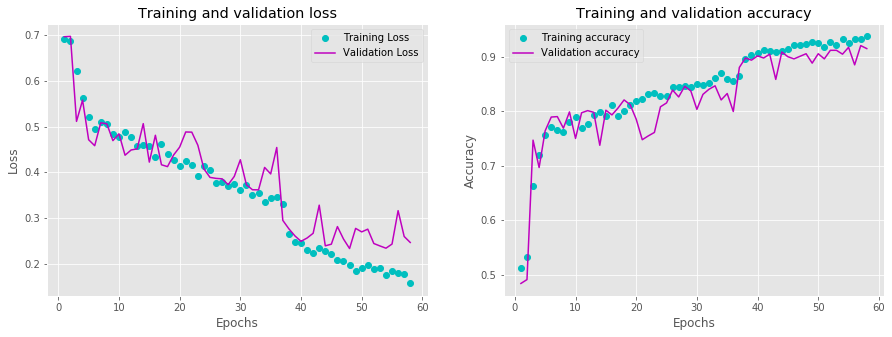

In [79]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs=range(1,len(history.history['loss'])+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [80]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)

54/54 [==============================] - 0s 3ms/step - loss: 0.2837 - acc: 0.9082


In [81]:
import scikitplot as skplt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_ks_statistic is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_ks_statistic instead.
  warnings.warn(msg, category=FutureWarning)


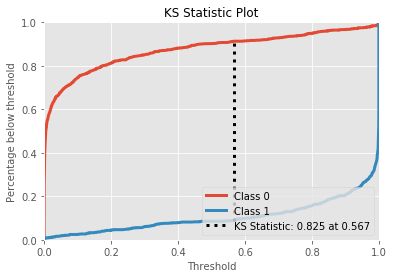

In [82]:
skplt.plotters.plot_ks_statistic(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=FutureWarning)


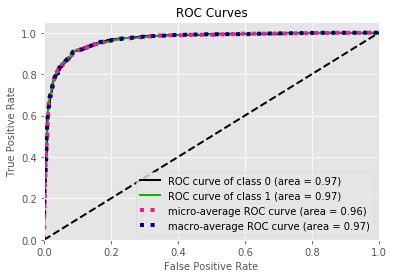

In [83]:
skplt.plotters.plot_roc_curve(y_test,y_pred)

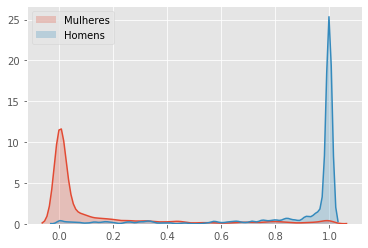

In [84]:
sb.kdeplot(y_pred[y_test==0,1],shade=True)
sb.kdeplot(y_pred[y_test==1,1],shade=True)
plt.legend(['Mulheres','Homens'])

In [72]:
import scipy.stats as st 

In [108]:
best_threshold=st.ks_2samp(y_pred[y_test==0,1],y_pred[y_test==1,1])[0]

In [109]:
metrics.confusion_matrix(y_test,y_pred[:,1]>best_threshold)/y_test.shape[0]

array([[0.47411765, 0.02117647],
       [0.08411765, 0.42058824]])

In [75]:
metrics.confusion_matrix(y_test,y_pred[:,1]>0.5)/y_test.shape[0]

array([[0.44647059, 0.04882353],
       [0.04294118, 0.46176471]])

# 

In [96]:
import winsound

In [97]:
winsound.Beep(440,1000)
winsound.Beep(660,1000)
winsound.Beep(220,1000)

In [17]:
import joblib

In [18]:
joblib.dump(trilha,'train_test.pickle',compress=True)

['train_test.pickle']